In [27]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle


import mido
from mido import MidiFile
from copy import deepcopy

from sklearn import metrics
from sklearn.metrics import _classification

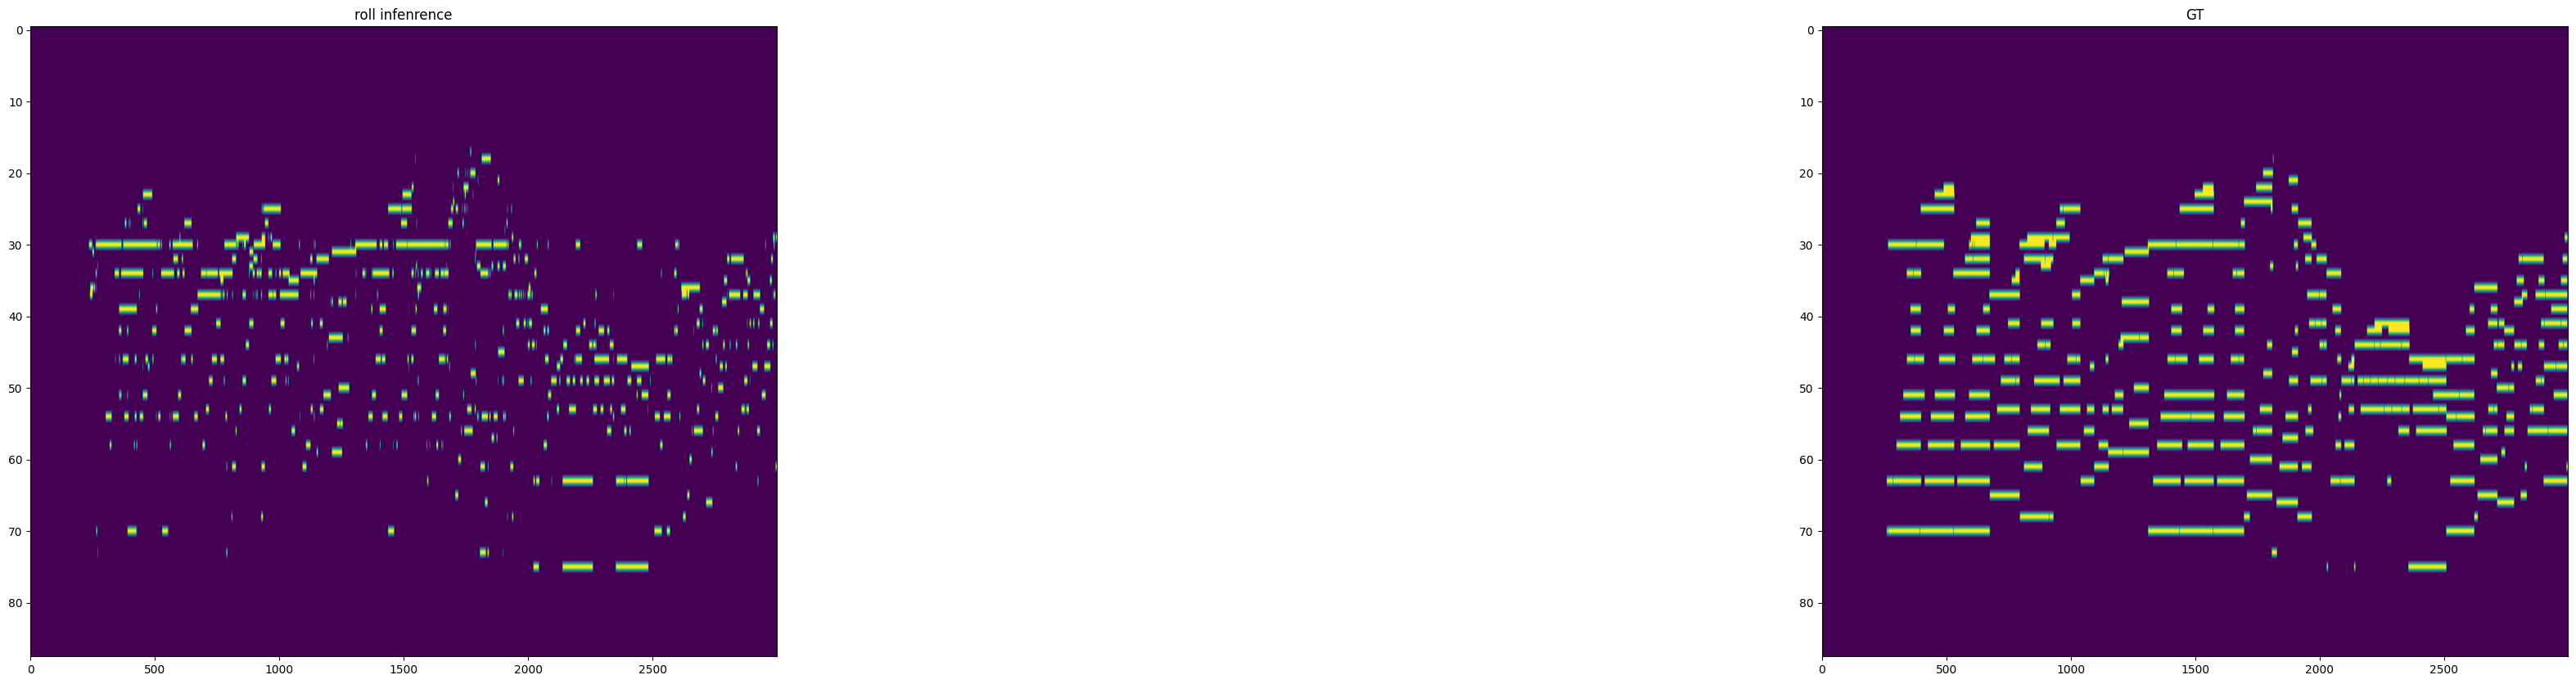

In [9]:
song_name = "116_“Méditation de Thaïs” Massenet PIANO SOLO + FREE SHEET MUSIC.mp4"
indices = slice(0, 3000)

plot_roll = True
plot_midi = False
plot_gt   = True

if plot_roll:
    test_roll_gen_path = os.path.join("./outputs_test/v2r_output", song_name)
    test_midi_gen_list = sorted(os.listdir(test_roll_gen_path), key=lambda x: int(x.split('-')[0]))
    test_midi_gen_list = [os.path.join(test_roll_gen_path, midi_gen) for midi_gen in test_midi_gen_list]
    midi_roll_cat = []
    for midi_gen in test_midi_gen_list:
        midi_roll_cat.append(np.load(midi_gen)['roll'])

if plot_midi:
    test_midi_gen_path = os.path.join("./outputs_test/r2m_output", song_name)
    test_midi_gen_list = sorted(os.listdir(test_midi_gen_path), key=lambda x: int(x.split('-')[0]))
    test_midi_gen_list = [os.path.join(test_midi_gen_path, midi_gen) for midi_gen in test_midi_gen_list]
    midi_gen_cat = []
    for midi_gen in test_midi_gen_list:
        midi_gen_cat.append(np.load(midi_gen)['midi'])

if plot_gt:
    gt = np.load(os.path.join("./data/ytdataset/labels_audeo/testing", song_name+".pkl"), allow_pickle=True)
    # gt = np.load(os.path.join("./data/MIDItest/labels/testing", song_name+".pkl"), allow_pickle=True)
    # gt = np.load(os.path.join("./data/bommelpiano_pad/labels/testing", song_name+".pkl"), allow_pickle=True)

    gt_np = []
    for k, v in gt.items():
        gt_np.append(v)

plt.figure(figsize=(40, 10))
if plot_roll:
    plt.subplot(1, 3, 1)
    plt.title("roll infenrence")
    plt.imshow(np.concatenate(midi_roll_cat, axis=0)[indices, ::-1].transpose(), aspect="auto")
    # plt.imshow(torch.sigmoid(torch.tensor(np.concatenate(midi_roll_cat, axis=0)[indices, ::-1].transpose().copy()))>0.05)
if plot_midi:
    plt.subplot(1, 3, 2)
    plt.title("midi inference")
    plt.imshow(np.pad(
        np.concatenate(midi_gen_cat, axis=0)[indices, ::-1].transpose(),
        ((0, 3), (0, 0)), 'constant', constant_values=0), aspect="auto")
if plot_gt:
    plt.subplot(1, 3, 3)
    plt.title("GT")
    plt.imshow(np.stack(gt_np)[indices, ::-1].transpose() > 0, aspect="auto")

In [2]:
def _prf_divide(numerator, denominator, zero_division="warn"):
    """Performs division and handles divide-by-zero.
    On zero-division, sets the corresponding result elements equal to
    0 or 1 (according to ``zero_division``). Plus, if
    ``zero_division != "warn"`` raises a warning.
    The metric, modifier and average arguments are used only for determining
    an appropriate warning.
    """
    mask = denominator == 0.0
    denominator = denominator.copy()
    denominator[mask] = 1  # avoid infs/nans
    result = numerator / denominator

    if not np.any(mask):
        return result

    # if ``zero_division=1``, set those with denominator == 0 equal to 1
    result[mask] = 0.0 if zero_division in ["warn", 0] else 1.0

    # the user will be removing warnings if zero_division is set to something
    # different than its default value. If we are computing only f-score
    # the warning will be raised only if precision and recall are ill-defined
    if zero_division != "warn":
        return result

In [11]:
from sklearn import metrics
from sklearn.metrics import _classification

# all_pred_label = np.pad(np.concatenate(midi_cat, axis=0), ((0, 0), (0, 3)), 'constant', constant_values=0)
all_pred_label = np.concatenate(midi_roll_cat, axis=0)
all_label = np.stack(gt_np)[:all_pred_label.shape[0]] > 1

labels = _classification._check_set_wise_labels(all_label, all_pred_label, labels=None, pos_label=1, average='samples')
MCM = metrics.multilabel_confusion_matrix(all_label, all_pred_label,sample_weight=None, labels=labels, samplewise=True)
tp_sum = MCM[:, 1, 1]
fp_sum = MCM[:, 0, 1]
fn_sum = MCM[:, 1, 0]
# tn_sum = MCM[:, 0, 0]
accuracy = _prf_divide(tp_sum, tp_sum+fp_sum+fn_sum, zero_division=1)
accuracy = np.average(accuracy)
all_precision = metrics.precision_score(all_label, all_pred_label, average=None, zero_division=np.nan)
all_recall = metrics.recall_score(all_label, all_pred_label, average=None, zero_division=np.nan)
all_f1_score = metrics.f1_score(all_label, all_pred_label, average=None, zero_division=np.nan)

all_precision_original = metrics.precision_score(all_label, all_pred_label, average="samples", zero_division=1)
all_recall_original = metrics.recall_score(all_label, all_pred_label, average="samples", zero_division=1)
all_f1_score_original = metrics.f1_score(all_label, all_pred_label, average="samples", zero_division=1)

In [12]:
print(np.nansum(all_precision) / np.count_nonzero(~np.isnan(all_precision)),
      np.nansum(all_recall) / np.count_nonzero(~np.isnan(all_recall)),
      np.nansum(all_f1_score) / np.count_nonzero(~np.isnan(all_f1_score)))

0.6627003964491157 0.3427260000859409 0.4056783412053171


In [13]:
print(accuracy, all_precision_original, all_recall_original, all_f1_score_original)

0.37367455052883625 0.723364081632653 0.42659376877091165 0.5658645727970982


In [3]:
def make_onset(roll: np.array):
    onset = np.zeros(roll.shape)
    for j in range(roll.shape[0]):
        if j != 0:
            onset[j][np.setdiff1d(roll[j].nonzero(),roll[j - 1].nonzero())] = 1
        else:
            onset[j][roll[j].nonzero()] = 1
    return onset

In [28]:
import torch

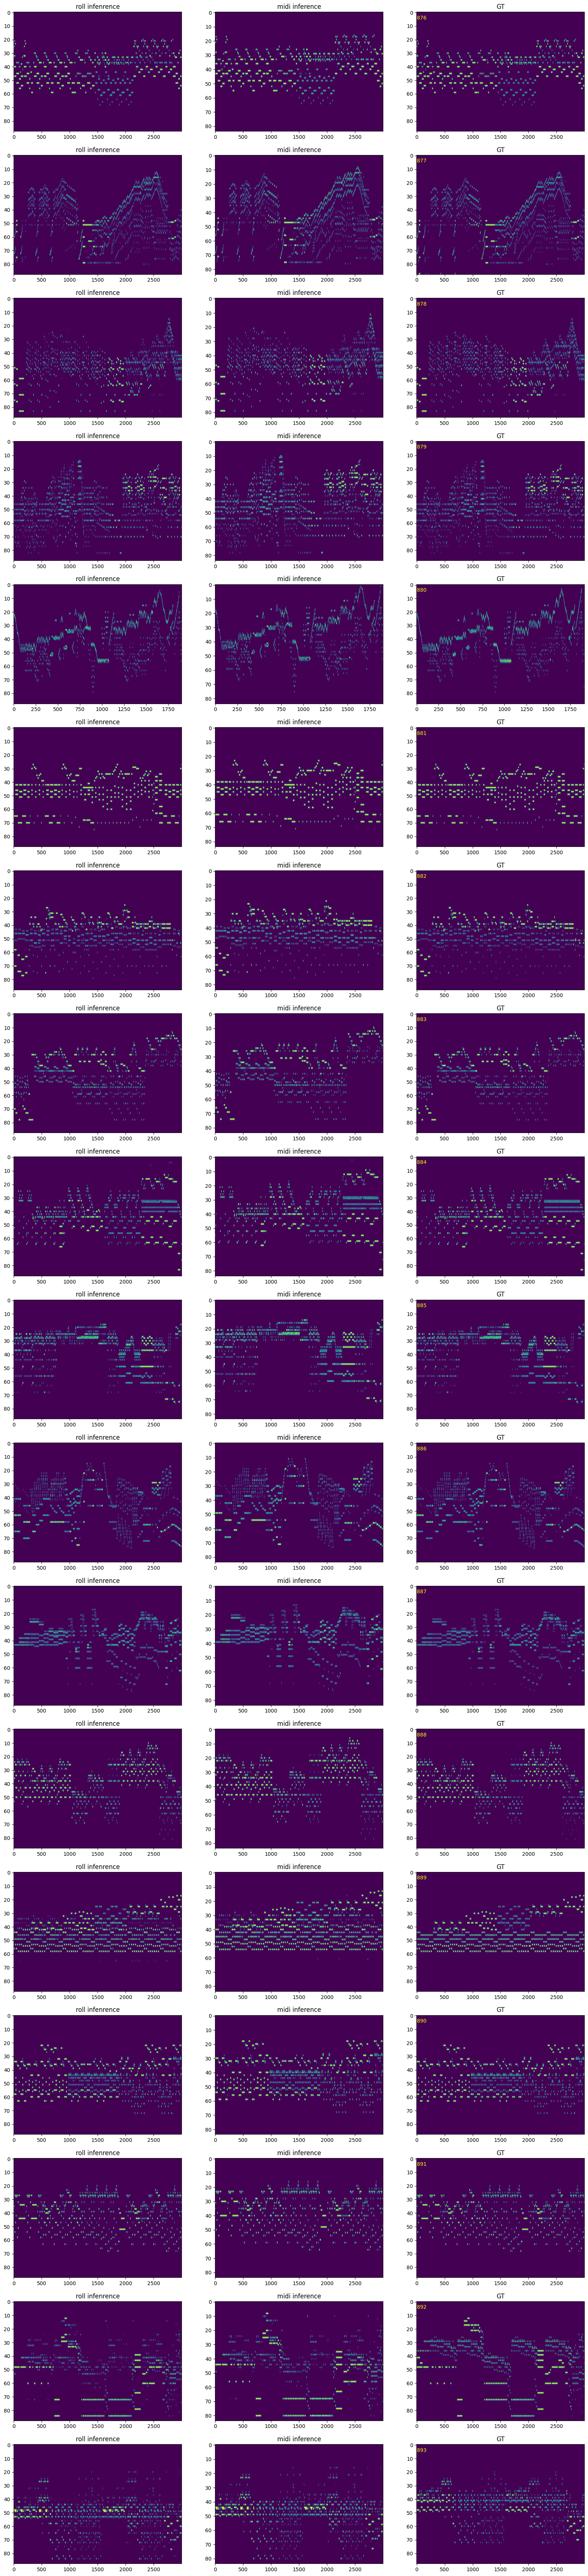

In [95]:
multi_infer_path_base = "./outputs/outputs_exp85_2fc"
multi_infer_path_roll = os.path.join(multi_infer_path_base, "v2r_output")
data_len = len(os.listdir(multi_infer_path_roll))
metrics_all = {}
plt.figure(figsize=(20, 5*data_len))
for i, names in enumerate(sorted(os.listdir(multi_infer_path_roll))):
    #if names == ".ipynb_ckechpoint
    song_name = names
    song_id = names.split("_")[0]
    indices = slice(0, 3000)

    plot_roll = True
    plot_midi = True
    plot_gt   = True

    if plot_roll:
        test_roll_gen_path = os.path.join(multi_infer_path_roll, song_name)
        test_midi_gen_list = sorted(os.listdir(test_roll_gen_path), key=lambda x: int(x.split('-')[0]))
        test_midi_gen_list = [os.path.join(test_roll_gen_path, midi_gen) for midi_gen in test_midi_gen_list]
        midi_roll_cat = []
        for midi_gen in test_midi_gen_list:
            midi_roll_cat.append(np.load(midi_gen)['roll'])

    if plot_midi:
        test_midi_gen_path = os.path.join(multi_infer_path_base, "r2m_output", song_name)
        test_midi_gen_list = sorted(os.listdir(test_midi_gen_path), key=lambda x: int(x.split('-')[0]))
        test_midi_gen_list = [os.path.join(test_midi_gen_path, midi_gen) for midi_gen in test_midi_gen_list]
        midi_gen_cat = []
        for midi_gen in test_midi_gen_list:
            midi_gen_cat.append(np.load(midi_gen)['midi'])

    if plot_gt:
        # gt = np.load(os.path.join("./data/ytdataset/labels_audeo/testing", song_name+".pkl"), allow_pickle=True)
        # gt = np.load(os.path.join("./data/MIDItest/labels/testing", song_name+".pkl"), allow_pickle=True)
        # gt = np.load(os.path.join("./data/bommelpiano/labels/testing", song_name+".pkl"), allow_pickle=True)
        # gt = np.load(os.path.join("./data/kassia/labels/testing", song_name+".pkl"), allow_pickle=True)
        gt = np.load(os.path.join("./data/rousseau/labels_align/testing", song_name+".pkl"), allow_pickle=True)

        gt_np = []
        for k, v in gt.items():
            gt_np.append(v)
    if plot_roll:
        plt.subplot(data_len, 3, i*3 + 1)
        plt.title("roll infenrence")
        plt.imshow(np.concatenate(midi_roll_cat, axis=0)[indices, ::-1].transpose(), aspect="auto")
        # plt.imshow(torch.sigmoid(torch.tensor(np.concatenate(midi_roll_cat, axis=0)[indices, ::-1].transpose().copy()))>0.05)
    if plot_midi:
        plt.subplot(data_len, 3, i*3 + 2)
        plt.title("midi inference")
        plt.imshow(np.pad(
            np.concatenate(midi_gen_cat, axis=0)[indices, ::-1].transpose(),
            ((0, 3), (0, 0)), 'constant', constant_values=0), aspect="auto")
    if plot_gt:
        plt.subplot(data_len, 3, i*3 + 3)
        plt.title("GT")
        plt.imshow(np.stack(gt_np)[indices, ::-1].transpose() > 0, aspect="auto")
        plt.text(0, 5, song_id, color="yellow")
        
    all_pred_label = np.concatenate(midi_roll_cat, axis=0)
    all_output_label = np.pad(np.concatenate(midi_gen_cat, axis=0), 
                              ((0, all_pred_label.shape[0]-np.concatenate(midi_gen_cat, axis=0).shape[0]), (3,4)))
    all_label = np.stack(gt_np)[:all_pred_label.shape[0]] > 0.1

    labels = _classification._check_set_wise_labels(all_label, all_pred_label, labels=None, pos_label=1, average='samples')
    MCM = metrics.multilabel_confusion_matrix(all_label, all_pred_label,sample_weight=None, labels=labels, samplewise=True)

    tp_sum = MCM[:, 1, 1]
    fp_sum = MCM[:, 0, 1]
    fn_sum = MCM[:, 1, 0]
    # tn_sum = MCM[:, 0, 0]
    accuracy = _prf_divide(tp_sum, tp_sum+fp_sum+fn_sum, zero_division=1)
    accuracy = np.average(accuracy)
    all_precision = metrics.precision_score(all_label, all_pred_label, average=None, zero_division=np.nan)
    all_recall = metrics.recall_score(all_label, all_pred_label, average=None, zero_division=np.nan)
    all_f1_score = metrics.f1_score(all_label, all_pred_label, average=None, zero_division=np.nan)

    all_precision_original = metrics.precision_score(all_label, all_pred_label, average="samples", zero_division=1)
    all_recall_original = metrics.recall_score(all_label, all_pred_label, average="samples", zero_division=1)
    all_f1_score_original = metrics.f1_score(all_label, all_pred_label, average="samples", zero_division=1)
    
    all_precision_midi = metrics.precision_score(all_label, all_output_label, average=None, zero_division=np.nan)
    all_recall_midi = metrics.recall_score(all_label, all_output_label, average=None, zero_division=np.nan)
    all_f1_score_midi = metrics.f1_score(all_label, all_output_label, average=None, zero_division=np.nan)
    
    
    metrics_all[song_id] = {
        "acc" : accuracy,
        "precision" : all_precision_original,
        "recall" : all_recall_original,
        "f1" : all_f1_score_original,
        "prec(nan division)" : np.nansum(all_precision) / np.count_nonzero(~np.isnan(all_precision)),
        "recall(nan division)" : np.nansum(all_recall) / np.count_nonzero(~np.isnan(all_recall)),
        "f1(nan division)" : np.nansum(all_f1_score) / np.count_nonzero(~np.isnan(all_f1_score)),
        "prec(roll)": np.nansum(all_precision_midi) / np.count_nonzero(~np.isnan(all_precision_midi)),
        "recall(roll)": np.nansum(all_recall_midi) / np.count_nonzero(~np.isnan(all_recall_midi)),
        "f1(roll)" : np.nansum(all_f1_score_midi) / np.count_nonzero(~np.isnan(all_f1_score_midi)),
    }

In [34]:
def onset_extend(array: np.array):
    array_base = array
    array_new = np.zeros_like(array_base)
    for i in range(-1, 2, 1):
        array_new += np.roll(array_base, i, axis=0)
    array_new[:2] = np.zeros_like(array_new[:2])
    array_new[-2:] = np.zeros_like(array_new[-2:])
    array_new = (array_new > 0.5).astype(np.float64)
    array_new += array_base
    return array_new

In [35]:
def custom_f1(label_onset_extend, pred_onset):
    eps = 1e-8
    label_onset_ext = label_onset_extend.copy()
    tp, fp, tn, fn = 0, 0, 0, 0
    for x, y in zip(*np.where(pred_onset == 1)):
        if label_onset_ext[x][y] > 0.5:
            tp += 1
            label_middle = (x + (np.where(label_onset_ext[x-1:x+2, y] == 2)[0] - 1))[0]
            label_onset_ext[label_middle-1:label_middle+2, y] = np.zeros(3,)
        else:
            fp += 1
    fn = len(np.where(label_onset_ext == 2)[0])
    
    p = tp / (tp + fp+eps)
    r = tp / (tp + fn+eps)

    f1 = 2*p*r / (p+r+eps)
    return p, r, f1

In [358]:
custom_f1(all_label_onset, all_output_label_onset)

(0.15331412103658032, 0.10791075050666163, 0.12666666181711245)

In [96]:
import pandas as pd

test_metrics_pd = pd.DataFrame.from_dict(dict(sorted(metrics_all.items(), key=lambda x: x[0])), orient='index')

In [13]:
test_metrics_pd["avg_note_len"] = [49.71967963386728,
 35.35964912280702,
 11.625094482237339,
 7.019632678910703,
 6.1758474576271185,
 7.3696719194006715,
 77.92765957446808,
 33.01335559265443,
 7.265799256505576,
 6.37037037037037,
 8.588014981273409,
 12.548257372654156,
 6.97289972899729,
 12.1790990990991,
 22.923599320882854,
 22.09806629834254,
 11.106206014075497,
 30.95736040609137,
 17.132251521298173]
# test_metrics_pd["avg_note_len"] = [57.4171270718232,
#  33.57880794701987,
#  11.45435684647303,
#  19.388034188034187,
#  13.334161490683229,
#  22.638186573670446,
#  58.88142292490119,
#  40.45034246575342,
#  36.48714069591528]

ValueError: Length of values (19) does not match length of index (18)

In [ ]:
test_metrics_pd["onset_count"] = [874.0,
 1140.0,
 2646.0,
 1579.0,
 1888.0,
 3871.0,
 470.0,
 599.0,
 1614.0,
 2025.0,
 1869.0,
 1492.0,
 738.0,
 2775.0,
 589.0,
 724.0,
 1563.0,
 985.0,
 2465.0]
# test_metrics_pd["onset_count"] = [362.0, 755.0, 482.0, 585.0, 805.0, 1147.0, 506.0, 584.0, 661.0]

In [379]:
test_metrics_pd["gap_mean"] =[10.397419354838709,
 12.509829619921364,
 5.1726829268292684,
 5.318840579710145,
 3.93853591160221,
 4.521465968586387,
 17.137305699481864,
 9.52431289640592,
 4.888449367088608,
 4.66577000672495,
 4.58416547788873,
 5.349356223175966,
 4.916211293260473,
 3.2835692835692836,
 9.460921843687375,
 4.8502581755593805,
 4.888586956521739,
 5.302863436123348,
 3.8683498647430117]
# test_metrics_pd["gap_mean"] = [10.738095238095237,
#  7.948863636363637,
#  5.358620689655172,
#  6.403645833333333,
#  6.036559139784946,
#  6.9,
#  12.250666666666667,
#  7.78239608801956,
#  9.533333333333333]

In [97]:
test_metrics_pd

acc  precision    recall        f1  prec(nan division)  \
876  0.868294   0.920428  0.934466  0.907387            0.766165   
877  0.767977   0.878503  0.857585  0.839041            0.835441   
878  0.839576   0.939956  0.883534  0.885323            0.875979   
879  0.898526   0.929497  0.964592  0.921049            0.862094   
880  0.800197   0.889754  0.877620  0.874104            0.834614   
881  0.925516   0.951646  0.970599  0.946516            0.934816   
882  0.880906   0.911482  0.961464  0.909950            0.826138   
883  0.931331   0.949898  0.978257  0.951654            0.760522   
884  0.858373   0.932510  0.910634  0.900709            0.691156   
885  0.888645   0.906041  0.980160  0.911098            0.855850   
886  0.700430   0.799298  0.826337  0.812981            0.747797   
887  0.838440   0.861468  0.972105  0.870858            0.759866   
888  0.920356   0.934589  0.983576  0.937403            0.758680   
889  0.741610   0.818435  0.877021  0.833210            0.788454   
890  0.862082   0.909256  0.936951  0.907890            0.784247   
891  0.942409   0.959090  0.979982  0.961933            0.882109   
892  0.397264   0.624980  0.480734  0.631685            0.506825   
893  0.523978   0.623972  0.673114  0.685401            0.477405   

     recall(nan division)  f1(nan division)  prec(roll)  recall(roll)  \
876              0.917286          0.904369    0.741509      0.936445   
877              0.816697          0.828010    0.752050      0.814184   
878              0.801564          0.816350    0.851436      0.802055   
879              0.929254          0.901881    0.782992      0.930433   
880              0.831485          0.831085    0.808713      0.784052   
881              0.949315          0.941599    0.908639      0.930850   
882              0.959070          0.899561    0.792340      0.961902   
883              0.940630          0.952979    0.844376      0.939229   
884              0.908834          0.918656    0.735412      0.918037   
885              0.981685          0.918741    0.826901      0.978127   
886              0.793185          0.766712    0.708852      0.802834   
887              0.967414          0.872213    0.716649      0.909025   
888              0.944417          0.903419    0.796999      0.935889   
889              0.913308          0.840406    0.754237      0.932970   
890              0.923712          0.908893    0.814859      0.923468   
891              0.973020          0.959660    0.921490      0.967967   
892              0.519629          0.497431    0.516890      0.530301   
893              0.563637          0.522398    0.462159      0.564830   

     f1(roll)  prec(test)  recall(test)  f1(test)  
876  0.898263    0.705394      0.687146  0.696151  
877  0.784565    0.797339      0.717764  0.755462  
878  0.800869    0.821739      0.764298  0.791978  
879  0.852535    0.948794      0.741374  0.832357  
880  0.799424    0.954545      0.824773  0.884927  
881  0.917728    0.750000      0.751648  0.750823  
882  0.880927    0.937447      0.929200  0.933305  
883  0.931548    0.914001      0.897418  0.905634  
884  0.910437    0.956329      0.951399  0.953858  
885  0.891690    0.908963      0.789967  0.845298  
886  0.750756    0.811852      0.669927  0.734092  
887  0.818435    0.923234      0.753667  0.829877  
888  0.874576    0.875569      0.797512  0.834720  
889  0.828856    0.461538      0.590551  0.518135  
890  0.895825    0.959930      0.959095  0.959512  
891  0.943778    0.986667      0.966746  0.976605  
892  0.495623    0.387001      0.380537  0.383742  
893  0.532647    0.449425      0.493679  0.470514

In [48]:
test_metrics_pd.to_csv(os.path.join(multi_infer_path_base, "output.csv"))

In [381]:
test_metrics_pd.corr()

acc  precision    recall        f1  \
acc                   1.000000  -0.220260  0.933085  0.927282   
precision            -0.220260   1.000000 -0.468709 -0.404145   
recall                0.933085  -0.468709  1.000000  0.855147   
f1                    0.927282  -0.404145  0.855147  1.000000   
prec(nan division)   -0.141176   0.918579 -0.409115 -0.270780   
recall(nan division)  0.956721  -0.298732  0.950560  0.880713   
f1(nan division)      0.974067  -0.094942  0.869701  0.895736   
prec(roll)            0.112329   0.667359 -0.143049  0.035415   
recall(roll)          0.957068  -0.315013  0.954347  0.883023   
f1(roll)              0.963076  -0.057409  0.841495  0.880410   
prec(test)            0.672913  -0.071205  0.688092  0.574552   
recall(test)          0.736302  -0.013927  0.651547  0.698408   
f1(test)              0.745325  -0.083864  0.716172  0.685062   
avg_note_len         -0.506089   0.438715 -0.633494 -0.420962   
onset_count           0.151669  -0.515353  0.287638  0.188256   
gap_mean             -0.158994   0.312061 -0.310733 -0.068633   

                      prec(nan division)  recall(nan division)  \
acc                            -0.141176              0.956721   
precision                       0.918579             -0.298732   
recall                         -0.409115              0.950560   
f1                             -0.270780              0.880713   
prec(nan division)              1.000000             -0.239326   
recall(nan division)           -0.239326              1.000000   
f1(nan division)               -0.001201              0.950020   
prec(roll)                      0.816653             -0.014795   
recall(roll)                   -0.264270              0.997085   
f1(roll)                        0.028612              0.919298   
prec(test)                     -0.144878              0.731041   
recall(test)                    0.038952              0.732644   
f1(test)                       -0.084584              0.773643   
avg_note_len                    0.601855             -0.541550   
onset_count                    -0.516154              0.171532   
gap_mean                        0.508290             -0.208506   

                      f1(nan division)  prec(roll)  recall(roll)  f1(roll)  \
acc                           0.974067    0.112329      0.957068  0.963076   
precision                    -0.094942    0.667359     -0.315013 -0.057409   
recall                        0.869701   -0.143049      0.954347  0.841495   
f1                            0.895736    0.035415      0.883023  0.880410   
prec(nan division)           -0.001201    0.816653     -0.264270  0.028612   
recall(nan division)          0.950020   -0.014795      0.997085  0.919298   
f1(nan division)              1.000000    0.247689      0.944267  0.989593   
prec(roll)                    0.247689    1.000000     -0.021601  0.320029   
recall(roll)                  0.944267   -0.021601      1.000000  0.920494   
f1(roll)                      0.989593    0.320029      0.920494  1.000000   
prec(test)                    0.685169    0.093922      0.745119  0.689682   
recall(test)                  0.774284    0.345665      0.735603  0.787518   
f1(test)                      0.766217    0.213391      0.783212  0.774808   
avg_note_len                 -0.397395    0.586175     -0.565598 -0.373044   
onset_count                   0.076506   -0.439026      0.184593  0.063873   
gap_mean                     -0.055716    0.607423     -0.234288 -0.038786   

                      prec(test)  recall(test)  f1(test)  avg_note_len  \
acc                     0.672913      0.736302  0.745325     -0.506089   
precision              -0.071205     -0.013927 -0.083864      0.438715   
recall                  0.688092      0.651547  0.716172     -0.633494   
f1                      0.574552      0.698408  0.685062     -0.420962   
prec(nan division)     -0.144878      0.038952 -0.084584      0.601855   
recall(nan division)    0.7

----------

In [142]:
np_gt = np.load("./data/kassia/labels/testing/682_GlinkaBalakirev – The Lark.mp4.pkl", allow_pickle=True)

In [146]:
np_midi = np.array(list(np_gt.values()))

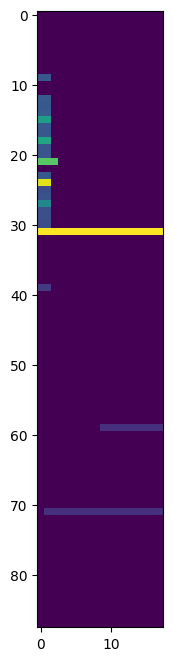

In [180]:
plt.figure(figsize=(30, 8))
plt.imshow(np_midi.T[::-1, 6107:6125])

In [181]:
np_midi[6108]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,  43.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,  52.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., 307.,  72.,  75.,  75., 142.,  77.,  72., 293.,  84.,   0.,
       227.,  81.,  81., 180.,  83.,  84., 171.,  88.,  85.,  88.,   0.,
         0.,  84.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [18]:
from glob import glob
from PIL import Image

In [13]:
img_list = glob("./data/rousseau/images_align/testing/892_Zedd - One Strange Rock (Piano Cover)/*.png")

In [15]:
img_list = sorted(img_list, key=lambda x: int(x.split("/")[-1].split(".")[0]))

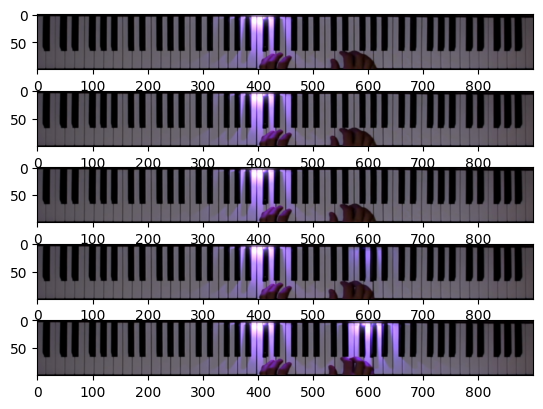

In [25]:
idx = 140
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.imshow(Image.open(img_list[idx+i]))

In [54]:
inference_best = sorted(glob("./outputs/outputs_exp62_46finetune_0.4/v2r_output/891_Yiruma - River Flows in You/*.npz"), key=lambda x: int(x.split("/")[-1].split("-")[0]))

In [60]:
inf_list = []
for np_inf in inference_best:
    np_obj = np.load(np_inf)['roll']
    inf_list.append(np_obj)
    
inf_best = np.concatenate(inf_list)
inf_best = inf_best.T[::-1]

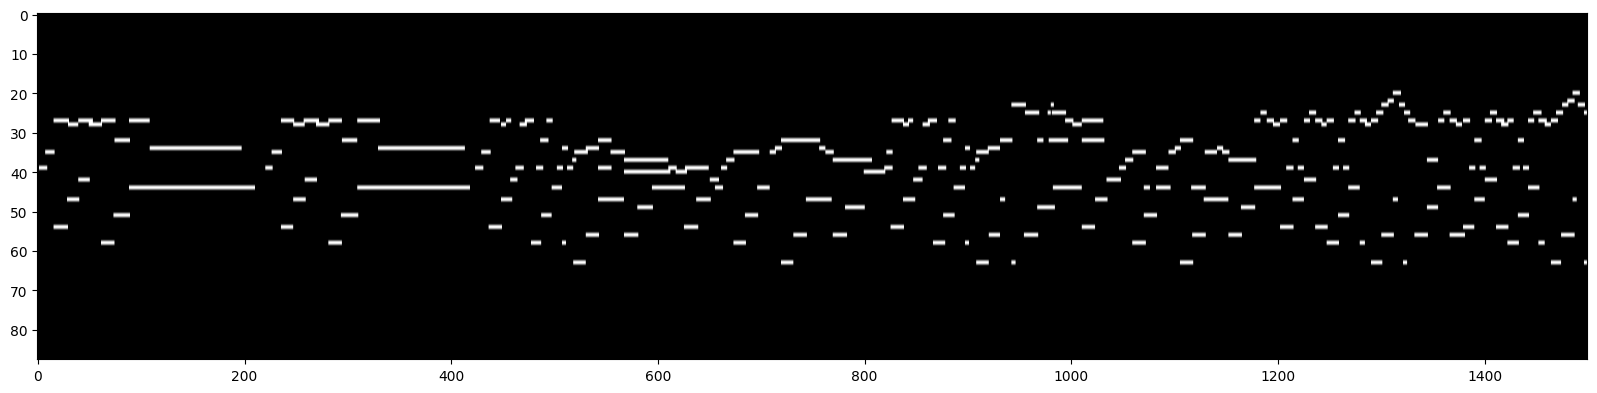

In [90]:
plt.figure(figsize=(20, 4.5))
plt.imshow(inf_best[:, :1500], aspect="auto", cmap="gray")

In [75]:
gt_best = np.load("./data/rousseau/labels_align/testing/891_Yiruma - River Flows in You.pkl", allow_pickle=True)

In [81]:
gt_best = np.stack(list(gt_best.values()))

In [83]:
gt_best = gt_best.T[::-1]

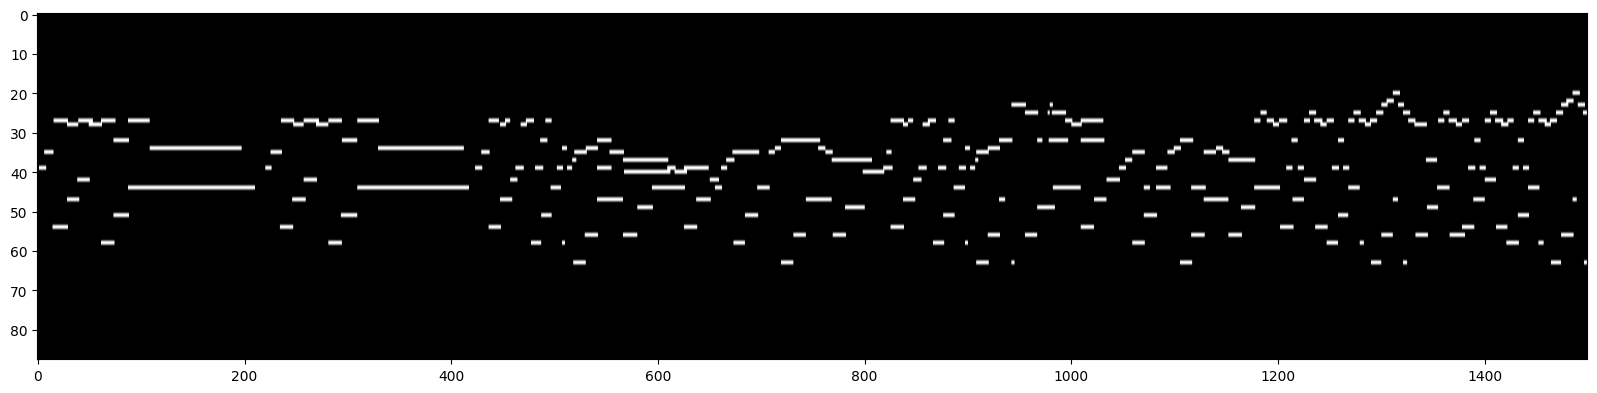

In [91]:
plt.figure(figsize=(20, 4.5))
plt.imshow(gt_best[:, :1500], aspect="auto", cmap="gray")